Import Required Modules

In [ ]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Dense, LSTM, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error
import statistics

Read the Given Dataset

In [ ]:
#Reading csv as dataframe
dt = pd.read_csv('AirQuality.csv', delimiter = ';', decimal = ',')

dt['Dates'] = pd.to_datetime(dt['Date'])
dt['Datetime'] = dt['Dates'].dt.strftime('%d/%m/%Y')
dt['Dates'] = pd.to_datetime(dt['Datetime'])  #Making columns for datetime

df1 = dt[6:342]

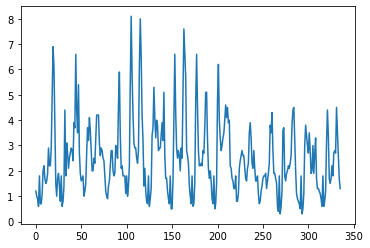

In [ ]:
datac=pd.read_csv('/content/drive/MyDrive/Hackathons/BlueSky/CO.csv')
# Extracting CO data
CO_data=datac['CO(GT)']
#visualizing CO data
CO_data.plot()

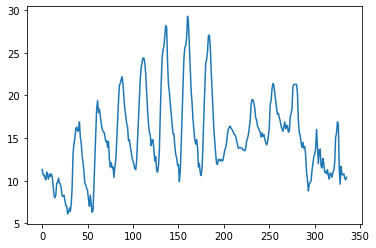

In [ ]:
datat=pd.read_csv('/content/drive/MyDrive/Hackathons/BlueSky/T.csv')
# Extracting Temperature data
Temp_data=datat['T']
#visualizing Temperature data
Temp_data.plot()

Data Preprocessing

In [ ]:
df_Temp = df1[['Dates', 'Time', 'T']]
df_Temp.reset_index(inplace = True)

In [ ]:
#Handling missing values (-200): Imputation with the mean of previous & next CO values
def handle_nan(dtf):
    for i in range(len(dtf)):
        if dtf.iloc[i]['T'] == -200:
            value_replace = (dtf.iloc[i-1]['T'] + dtf.iloc[i+1]['T'])/2
            dtf.loc[i, 'T'] = value_replace
    return dtf

In [ ]:
def clean_dt_hr(dtf):
    for i in range(len(dtf)):
        hour_ = int(dtf['Time'][i][:2])
        dum_replace = dtf.loc[i, 'Dates'].replace(hour = hour_)
        dtf.loc[i, 'Dates'] = dum_replace
    return dtf

In [ ]:
df_Temp1 = handle_nan(df_Temp)
clean_df = clean_dt_hr(df_Temp1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
#Generating time-series
clean_df1 = clean_df[['Dates', 'T']]

series_df = pd.Series(clean_df1['T'].values, index = clean_df1['Dates'])
re_df = pd.Series(series_df.values.reshape(-1,))

Splitting the data

In [ ]:
#Split the sequence as samples
def split_s(s, n_steps):
    X, y = list(), list()
    for i in range(len(s)):
        end_ix = i + n_steps
        if end_ix > len(s)-1:
            break
        x_sequence, y_sequence = s[i:end_ix], s[end_ix]
        X.append(x_sequence)
        y.append(y_sequence)
    return np.array(X), np.array(y)

In [ ]:
def seq(pts):
    X_Temp, y_Temp = split_s(pts, n_steps)
    return X_Temp, y_Temp

In [ ]:
def seq_traintest(X_Temp, y_Temp):
    X_train, y_train = X_Temp[:144-n_steps], y_Temp[:144-n_steps]
    X_v, y_v = X_Temp[144-n_steps:], y_Temp[144-n_steps:]
    return X_train, y_train, X_v, y_v

Creating Model

In [ ]:
#Model Definition
def Fin_model(unit):
    model = Sequential()  
    model.add(LSTM(units=unit, input_shape=(n_steps, 1), activation = 'relu'))  
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))  
    
    model.compile(optimizer = 'adam', loss = 'mean_absolute_percentage_error')
    return model

In [ ]:
#Function for Training Model
def model_training(model, b_size, idx):
    eS = EarlyStopping(monitor='val_loss', patience=500, verbose=0, mode='min')
    mcp_save = ModelCheckpoint('temp_model_%s.hdf5'%idx, save_best_only=True, 
                           monitor='val_loss', mode='min')
    lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, 
                                       verbose=1, min_delta=1e-5, mode='min')
    
    model1 = model.fit(X_train, y_train, epochs = 200, validation_data = (X_v, y_v), 
              batch_size = b_size, verbose = 2,
              callbacks=[eS, mcp_save, lr_loss]
             )
    return model1

Train Model

In [ ]:
n_steps = 15
units = 50
batch_size = 16

start = datetime.datetime.now()

model_fin = Fin_model(units)

mape_t = []
mod_t = []
pred_t = []

for ind in range(7):
    X_Temp, y_Temp = seq(re_df[24*ind:24*(ind+7)].values)
    X_train, y_train, X_v, y_v = seq_traintest(X_Temp, y_Temp)
    
    model1 = model_training(model_fin, batch_size, ind)
    best_model = load_model('temp_model_%s.hdf5'%ind)
    mod_t.append(best_model)
    
    X_test, y_test = seq(re_df[24*(ind+7)-n_steps:24*(ind+8)].values)

    predicted = best_model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, predicted)
    
    pred_t.extend(predicted)
    mape_t.append(mape)
    print('Forecasting for %s done, train and val set used is from %s until %s'%(series_df.index[24*(ind+7)].date(), series_df.index[24*(ind)].date(), series_df.index[24*(ind+6)].date()))
            
            
print("time needed for all process --> ", datetime.datetime.now()-start)

Epoch 1/200
9/9 - 1s - loss: 62.8318 - val_loss: 35.0185 - lr: 0.0010 - 1s/epoch - 147ms/step
Epoch 2/200
9/9 - 0s - loss: 48.8014 - val_loss: 28.8368 - lr: 0.0010 - 82ms/epoch - 9ms/step
Epoch 3/200
9/9 - 0s - loss: 35.5991 - val_loss: 27.6765 - lr: 0.0010 - 98ms/epoch - 11ms/step
Epoch 4/200
9/9 - 0s - loss: 33.1271 - val_loss: 16.7162 - lr: 0.0010 - 91ms/epoch - 10ms/step
Epoch 5/200
9/9 - 0s - loss: 28.5921 - val_loss: 30.2883 - lr: 0.0010 - 76ms/epoch - 8ms/step
Epoch 6/200
9/9 - 0s - loss: 31.7404 - val_loss: 15.7866 - lr: 0.0010 - 87ms/epoch - 10ms/step
Epoch 7/200
9/9 - 0s - loss: 31.6233 - val_loss: 27.5720 - lr: 0.0010 - 76ms/epoch - 8ms/step
Epoch 8/200
9/9 - 0s - loss: 26.2313 - val_loss: 14.2810 - lr: 0.0010 - 91ms/epoch - 10ms/step
Epoch 9/200
9/9 - 0s - loss: 26.3048 - val_loss: 24.2964 - lr: 0.0010 - 72ms/epoch - 8ms/step
Epoch 10/200
9/9 - 0s - loss: 24.4650 - val_loss: 19.9020 - lr: 0.0010 - 76ms/epoch - 8ms/step
Epoch 11/200
9/9 - 0s - loss: 23.3266 - val_loss: 15.03

In [ ]:
dl = [str(series_df.index[24*(ind+7)].date()) for ind in range(7)]

In [ ]:
mod_t[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


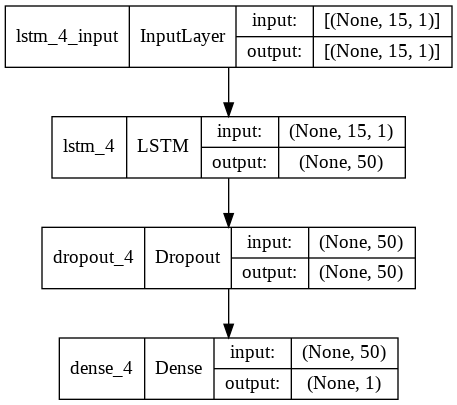

In [ ]:
import tensorflow as tf
mod=Fin_model(50)
tf.keras.utils.plot_model(mod, show_shapes=True)

Avg MAPE & MAPE for all days

In [ ]:
mape_vals = statistics.mean(mape_t)
mape_t.append(mape_vals)

dl.append('Average')

error_val = pd.DataFrame(list(zip(dl, mape_t)),
                       columns = ['Date', 'MAPE'])

error_val

,Date,MAPE
0,2004-03-18,0.053278
1,2004-03-19,0.023687
2,2004-03-20,0.018232
3,2004-03-21,0.026815
4,2004-03-22,0.042004
5,2004-03-23,0.085295
6,2004-03-24,0.077171
7,Average,0.046640


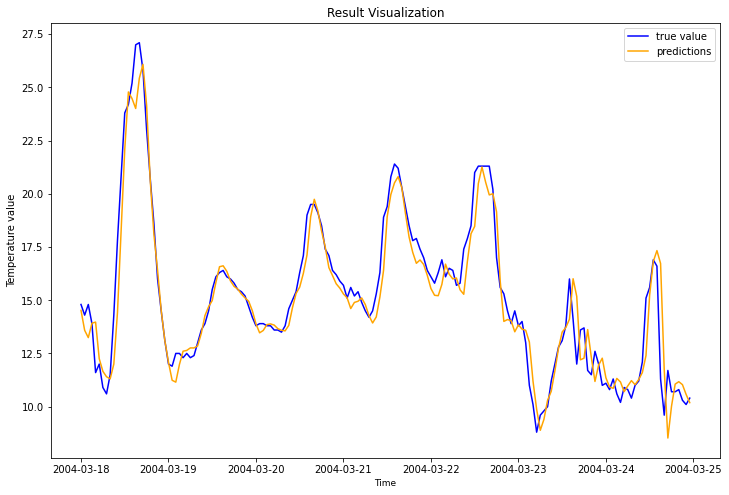

In [ ]:
# Plot temp predictions
index = series_df.index

plt.figure(figsize=(12,8))
plt.plot(index[168:], series_df[168:].values, color = 'blue', label = 'true value')
plt.plot(index[168:], pred_t, color = 'orange', label = 'predictions')
plt.title('Result Visualization', fontsize=12) 
plt.xlabel('Time', fontsize=9)
plt.ylabel("Temperature value", fontsize=10)
plt.legend()
plt.show()

In [ ]:
# Generate output csv with predictions
pred_dt = [series_df.index[i] for i in range(168,336)]
pred_tl = [pred_t[i][0] for i in range(len(pred_t))]
preds = pd.DataFrame(list(zip(pred_dt, pred_tl)), columns = ['Date', 'pred_temp'])
preds.to_csv('temp_predictions.csv')